# Merge the prophage predictions with RAST metadata

Combine RAST metadata and prophage predictions

In [157]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse
from datetime import datetime
import pytz

import subprocess
import gzip


In [2]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### Date conversion

This routine is used to convert the dates into something useable. Here we choose a point in time (i.e. now) and set all dates to be relative to that. We use years as our unit, but could also use seconds.

In [253]:
# Convert the collection date to a number. We take todays date, and then convert relative to that
# it allows dates pre-epoch

yr = re.compile("^[~]*(\d{4})['s]*$")
yrranged = re.compile("^(\d{4})\s*-\s*\d{4}$")
yrranges = re.compile("^(\d{4})\s*/\s*(\d{4})$")
myd = re.compile('^\d{1,4}/\d{1,2}/\d{1,4}$')
lem = re.compile("^late\s*|^early\s*|^mid\s*|^prior to\s*")
splitseen = set()
adate = datetime.now()
adate = adate.replace(tzinfo=pytz.UTC)

def convert_date(x):
    if pd.isna(x):
        return np.nan
    
    if x.lower() == 'not collected' or x.lower() == 'not applicable' or x.lower() == 'not available: not collected':
        return np.nan

    # a few one off cases that are just easier to fix
    if 'May 2015-Nov 2015' == x:
        x = 'May 2015'
    
    if '1954-65' == x:
        x = '01 January 1954'
        
    if 'Jul-00' == x:
        x = 'Jul-2000'

    if '2015_9' == x:
        x = 'Sep-2015'
    
    if '31-Mac-2013' == x:
        x = '31-May-2013'
     
    x = lem.sub('', x)
    if '/' in x:
        if not myd.match(x):
            m = yrranges.match(x)
            if m:
                x = m.groups()[1]
            else:
                if x not in splitseen:
                    sys.stderr.write(f"Splitting {x}\n")
                    splitseen.add(x)
                p = x.split('/')
                x = p[1]
    
    
    m = yr.match(x)
    if m:
        x = '01 January ' + m.groups()[0]
    else:
        m = yrranged.match(x)
        if m:
            x = '01 January ' + m.groups()[0]


    try:
        dt = parse(x)
    except:
        if '-' in x:
            p = x.split('-')
            dt = parse(p[1])
        else:
            sys.stderr.write(f"Can't convert |{x}|\n")
            return np.nan
    
    dt = dt.replace(tzinfo=pytz.UTC)
    
    
    if dt < adate:
        tdelt = adate - dt
        seconds = -1 * ((tdelt.days * 86400) + tdelt.seconds)
    else:
        tdelt = dt - adate
        seconds = (tdelt.days * 86400) + tdelt.seconds
    
    # convert seconds to years
    return seconds/31557600 

In [306]:
# Convert the collection date to a number. We take todays date, and then convert relative to that
# it allows dates pre-epoch

yr = re.compile("^[~]*(\d{4})['s]*$")
yrrange = re.compile("^(\d{4})\s*.\s*(\d{4})$")
myd = re.compile('^\d{1,4}/\d{1,2}/\d{1,4}$')
damoyrrange = re.compile('^(\d+\s+\w+\s+\d{4})\s*.{1,3}?\s*(\d+\s+\w+\s+\d{4})$')
modacyrrange = re.compile('^(\w+\s+\d+,*\s+\d{4})\s*.{1,3}?\s*(\w+\s+\d+,*\s+\d{4})$')
moyrrange = re.compile('^(\w+\s+\d{4})\s*.{1,3}?\s*(\w+\s+\d{4})$')
year42 = re.compile('^(\d{4})-\d{2}$')
lem = re.compile("^late\s*|^early\s*|^mid\s*|^prior to\s*|^before\s*|^pre-", re.IGNORECASE)
splitseen = set()
adate = datetime.now()
adate = adate.replace(tzinfo=pytz.UTC)

def try_parsing(x):
    """
    Attempt to parse a date, and catch an error.
    
    If we fail, we return None, otherwise we return the years since now()
    """
    try:
        dt = parse(x)
    except:
        return None
    
    dt = dt.replace(tzinfo=pytz.UTC)
    
    if dt < adate:
        tdelt = adate - dt
        seconds = -1 * ((tdelt.days * 86400) + tdelt.seconds)
    else:
        tdelt = dt - adate
        seconds = (tdelt.days * 86400) + tdelt.seconds
    # convert seconds to years
    return seconds/31557600 
    

def convert_date_too(x):
    """
    Convert the date to years and fractions.
    
    We try several times, and clean it up as we go along.    
    """
    if pd.isna(x):
        return np.nan

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
    orix = x
    
    if x.lower() in ['restricted access', 'none', 'not collected', 'not applicable', 'not available: not collected', 'unspecified']:
        return np.nan
   
    # a few one off cases that are just easier to fix
    if 'May 2015-Nov 2015' == x:
        x = 'May 2015'
    
    if '1954-65' == x:
        x = '01 January 1954'
        
    if 'Jul-00' == x:
        x = 'Jul-2000'

    if '2015_9' == x:
        x = 'Sep-2015'
    
    if '31-Mac-2013' == x:
        x = '31-May-2013'
     
    x = lem.sub('', x)
    
        
    if '_' in x:
        x = x.replace('_', '-')
        
    x = x.replace(' or earlier', '')
    x = x.replace('collected in the ', '')
        
    # some regular expressions of variants of day month year - day month year ranges. We choose 1
    m = yrrange.match(x)
    if m:
        x = '01 January ' + m.groups()[1]

    m = yr.match(x)
    if m:
        x = '01 January ' + m.groups()[0]

    m = year42.match(x)
    if m:
        x = '01 January ' + m.groups()[0]
            
    m = modacyrrange.match(x)
    if m:
        x = m.groups()[1]
        
    m = damoyrrange.match(x)
    if m:
        x = m.groups()[1]
    
    m = moyrrange.match(x)
    if m:
        x = '01 ' + m.groups()[1]
        
    
        
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
          
    if '/' in x:
        if x not in splitseen:
            # sys.stderr.write(f"Splitting {x}\n")
            splitseen.add(x)
        p = x.split('/')
        x = p[1]
   
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
   
    else:
        m = yrranged.match(x)
        if m:
            x = '01 January ' + m.groups()[0]

    if x.endswith('-00'):
        x = x.replace('-00', '-2000')

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt

    
    sys.stderr.write(f"can't parse |{x}| from |{orix}|\n")
            
    return np.nan

### Read the data file

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [305]:
# the full data set. Don't try this at home!
# metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
metadf['years_ago'] = metadf.collection_date.apply(convert_date_too)
metadf

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
can't parse |1999 and 2000| from |1999 and 2000|
can't parse |0-Apr-2008| from |0-Apr-2008|
can't parse |CGMCC No.5392| from |CGMCC No.5392|
can't parse |CGMCC No.5392| from |CGMCC No.5392|


,genome_id,genome_name,organism_name,taxon_id,genome_status,strain,serovar,biovar,pathovar,mlst,...,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,comments,additional_metadata,years_ago
0,469009.4,"""'Brassica napus' phytoplasma strain TW1""",NaN,469009,WGS,TW1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Genome sequence of a strain of bacteria that c...,sample_type:metagenomic assembly;collected_by:...,-3.646018
1,1309411.5,"""'Deinococcus soli' Cha et al. 2014 strain N5""",NaN,1309411,Complete,N5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Genome sequencing of a Gamma-Radiation-Resista...,sample_type:bacterial,-8.001939
2,1123738.3,"""'Echinacea purpurea' witches'-broom phytoplas...",NaN,1123738,WGS,NCHU2014,NaN,NaN,NaN,NaN,...,NaN,NaN,C,NaN,NaN,NaN,NaN,'Echinacea purpurea' witches'-broom phytoplasm...,lab_host:Catharanthus roseus,-6.852041
3,551115.6,"""'Nostoc azollae' 0708""",'Nostoc azollae' 0708,551115,Complete,708,NaN,NaN,NaN,NaN,...,NaN,Mesophilic,-,NaN,Aerobic,Multiple,NaN,"Nostoc azollae 0708. Nostoc azollae 0708, also...",NaN,NaN
4,1856298.3,"""'Osedax' symbiont bacterium Rs2_46_30_T18 str...",NaN,1856298,WGS,Rs2_46_30_T18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"In this study, we simulate the Deepwater Horiz...",sample_type:metagenomic assembly,-7.698037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433517,1131286.3,zeta proteobacterium SCGC AB-137-J06,zeta proteobacterium SCGC AB-137-J06,1131286,WGS,SCGC AB-137-J06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433518,1131287.3,zeta proteobacterium SCGC AB-602-C20,zeta proteobacterium SCGC AB-602-C20,1131287,WGS,SCGC AB-602-C20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433519,1131288.3,zeta proteobacterium SCGC AB-602-E04,zeta proteobacterium SCGC AB-602-E04,1131288,WGS,SCGC AB-602-E04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433520,1131289.3,zeta proteobacterium SCGC AB-604-B04,zeta proteobacterium SCGC AB-604-B04,1131289,WGS,SCGC AB-604-B04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [4]:
acccol = 'assembly_accession'
metadf[acccol]

0         GCA_003181115.1
1         GCF_001007995.1
2         GCF_001307505.1
3         GCA_000196515.1
4         GCA_002163025.1
               ...       
433517    GCA_000379245.1
433518    GCA_000379345.1
433519    GCA_000379265.1
433520    GCA_000379205.1
433521    GCA_000372125.1
Name: assembly_accession, Length: 433522, dtype: object

### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [5]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

#phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf], axis=1)
phagesdf

,assembly_accession,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...
399577,GCA_902860175.1,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,21,33,2,14,17,69051
399578,GCA_902860185.1,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,8,22,0,10,12,0
399579,GCA_902860195.1,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,148,33,1,11,21,12819
399580,GCA_902860205.1,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,19,35,2,21,12,41572


### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames. We write this to a tsv file for Laura to append isolation information to.

In [224]:
interesting_cols = [acccol, 'isolation_site', 'isolation_source', 'isolation_comments', 'collection_date',
                    'isolation_country', 'geographic_location', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease']

tempdf = metadf[interesting_cols]
phagemeta = pd.merge(tempdf, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

In [7]:
phagemeta

,assembly_accession,isolation_site,isolation_source,isolation_comments,collection_date,isolation_country,geographic_location,latitude,longitude,altitude,...,disease,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,NaN,cream cheese,isolated from cream cheese,NaN,NaN,NaN,NaN,NaN,NaN,...,Food poisoning,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,NaN,soil,isolated from soil,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,NaN,human blood,isolated from human blood in Iceland,NaN,Iceland,Iceland,NaN,NaN,NaN,...,Food poisoning,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,NaN,soil,isolated from soil in New York State by alkali...,NaN,United States,New York State,NaN,NaN,NaN,...,NaN,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403548,GCA_902860175.1,NaN,Laboratory sink,NaN,0000,NaN,NaN,NaN,NaN,NaN,...,NaN,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,21,33,2,14,17,69051
403549,GCA_902860185.1,NaN,Human,NaN,0000,United Kingdom,United Kingdom,NaN,NaN,NaN,...,NaN,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,8,22,0,10,12,0
403550,GCA_902860195.1,NaN,Human,NaN,0000,United Kingdom,United Kingdom,NaN,NaN,NaN,...,NaN,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,148,33,1,11,21,12819
403551,GCA_902860205.1,NaN,NaN,NaN,0000,NaN,NaN,NaN,NaN,NaN,...,NaN,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,19,35,2,21,12,41572


In [7]:
phagemeta.iloc[:,2:29]

,isolation_source,isolation_comments,collection_date,isolation_country,geographic_location,latitude,longitude,altitude,depth,other_environmental,...,gram_stain,cell_shape,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,+,Rod,No,No,Mesophilic,-,NaN,Anaerobic,Host-associated,NaN
1,cream cheese,isolated from cream cheese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,+,Rod,Yes,Yes,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning
2,soil,isolated from soil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,+,Rod,No,Yes,NaN,-,NaN,NaN,NaN,NaN
3,human blood,isolated from human blood in Iceland,NaN,Iceland,Iceland,NaN,NaN,NaN,NaN,NaN,...,+,Rod,Yes,Yes,Mesophilic,-,NaN,Aerobic,Multiple,Food poisoning
4,soil,isolated from soil in New York State by alkali...,NaN,United States,New York State,NaN,NaN,NaN,NaN,NaN,...,NaN,Bacilli,Yes,NaN,Mesophilic,NaN,NaN,Facultative,Terrestrial,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403548,Laboratory sink,NaN,0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403549,Human,NaN,0000,United Kingdom,United Kingdom,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403550,Human,NaN,0000,United Kingdom,United Kingdom,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403551,NaN,NaN,0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
phagemeta['isolation_source'].astype('category').cat.codes

0           -1
1         5261
2         8897
3         6481
4         8897
          ... 
403548    2025
403549    1762
403550    1762
403551      -1
403552     115
Length: 403553, dtype: int16

In [9]:
phagemeta.iloc[:,34:35]

,Kept
0,2
1,1
2,6
3,6
4,3
...,...
403548,2
403549,0
403550,1
403551,2


## Encode the data

This converts every column into categories so we can (hopefully) use it in the RF models

In [61]:
pmenc = pd.DataFrame()
for c in phagemeta.iloc[:,2:29].columns:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc

,isolation_source,isolation_comments,collection_date,isolation_country,geographic_location,latitude,longitude,altitude,depth,other_environmental,...,gram_stain,cell_shape,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,56,5,3,8,1,-1,3,14,-1
1,5261,1990,-1,-1,-1,-1,-1,-1,-1,-1,...,0,56,9,8,8,1,-1,1,23,159
2,8897,2657,-1,-1,-1,-1,-1,-1,-1,-1,...,0,56,5,8,-1,1,-1,-1,-1,-1
3,6481,2208,-1,93,2666,-1,-1,-1,-1,-1,...,0,56,9,8,8,1,-1,1,23,159
4,8897,2688,-1,228,4088,-1,-1,-1,-1,-1,...,-1,13,9,-1,8,-1,-1,5,37,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403548,2025,-1,0,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
403549,1762,-1,0,227,7171,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
403550,1762,-1,0,227,7171,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
403551,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Random Forest

Can we identify which features best predict the number of phages predicted. Note we should compare total/kept/etc

First, an RF with all the data. You might want to skip this!

In [65]:
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(pmenc, phagemeta.Kept.values.ravel())
print(rf)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=42)


## Important features

What are the most important features for predicting the number of prophages in a genome?

In [82]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf

,feature,importance
2,collection_date,0.249231
0,isolation_source,0.185685
4,geographic_location,0.166329
3,isolation_country,0.076014
10,host_name,0.064225
1,isolation_comments,0.042593
13,host_health,0.029906
9,other_environmental,0.024719
16,other_clinical,0.022911
8,depth,0.019943


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)

lab = ax.get_xticklabels()
print(f"{[x.get

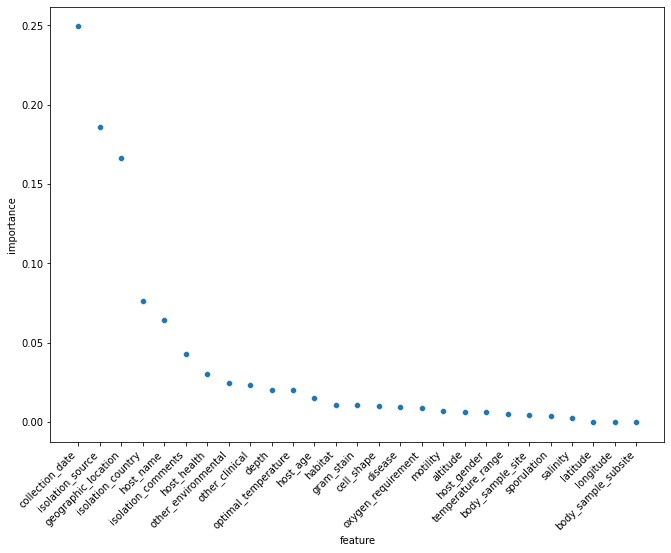

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')
fig.savefig(f"images/rf_importance.svg")

In [106]:
printmd("**Random Forest output**", "blue")
printmd(f"There were {rf.n_features_} _features_ (columns in the dataframe), and {rf.n_classes_} _classes_ (unique categories)")
printmd(f"The OOB error was {rf.oob_score_}")

<span style='color:blue'>**Random Forest output**</span>

<span style='color:black'>There were 27 _features_ (columns in the dataframe), and 56 _classes_ (unique categories)</span>

<span style='color:black'>The OOB error was 0.1636910145631429</span>

### Collection date

So it seems that collection date is important. Lets explore this further and convert to a real date and time

In [213]:
cdnn['years_ago'] = cdnn.collection_date.apply(convert_date)

Can't convert |1999 and 2000|
Splitting 11/2007
Can't convert |Between 2002 and 2005|
Can't convert |CGMCC No.5392|
Can't convert |31-Mac-2013|
Can't convert |Unspecified|
Can't convert |restricted access|
Splitting 28-Jun-2016/30-Jun-2016
Splitting 31-Jul-2014/02-Aug-2014
Splitting 2016-07/2017-08
Splitting Jun-2009/Oct-2009
Splitting 30-Apr-2011/05-May-2011
Splitting Jul-2001/ Jun-2004
Splitting 2015-10/2015-11
Splitting 09-Aug-2010/13-Aug-2010
Splitting 2014/2015/2016
Splitting 2017-12/2018-11
Splitting Jan-2015/July-2016
Splitting 22-May-2017/13-Oct-2017
Splitting Feb-2011/Nov-2011
Splitting 01-Jan-2012/01-Jan-2017
Splitting 2010-01-01/2014-12-31


In [214]:
cdnn[cdnn['years'].notnull()].sort_values('years')

,collection_date,Kept,years
78916,1819-08-20,4,-201.630561
84232,1883,2,-138.263004
402183,1885,8,-136.261635
380373,1889,7,-132.261635
203133,1895,6,-126.263004
...,...,...,...
402128,Nov-05,2,0.578885
7936,Nov-10,10,0.592574
10163,Nov-11,1,0.595312
47315,Nov-13,14,0.600788


In [193]:
phagemeta.loc[401558]

assembly_accession                                    GCA_900618215.1
isolation_site                                                    NaN
isolation_source                                                  NaN
isolation_comments                                                NaN
collection_date                                             1800/2014
isolation_country                                                 NaN
geographic_location                                               NaN
latitude                                                          NaN
longitude                                                         NaN
altitude                                                          NaN
depth                                                             NaN
other_environmental                                               NaN
host_name                                                         NaN
host_gender                                                       NaN
host_age            

<AxesSubplot:xlabel='years', ylabel='Kept'>

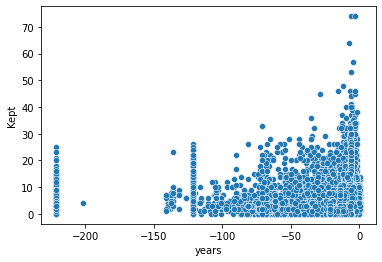

In [188]:
sns.scatterplot(x='years', y='Kept', data=cdnn[cdnn['years'].notnull()])

<AxesSubplot:xlabel='isolation_source', ylabel='Kept'>

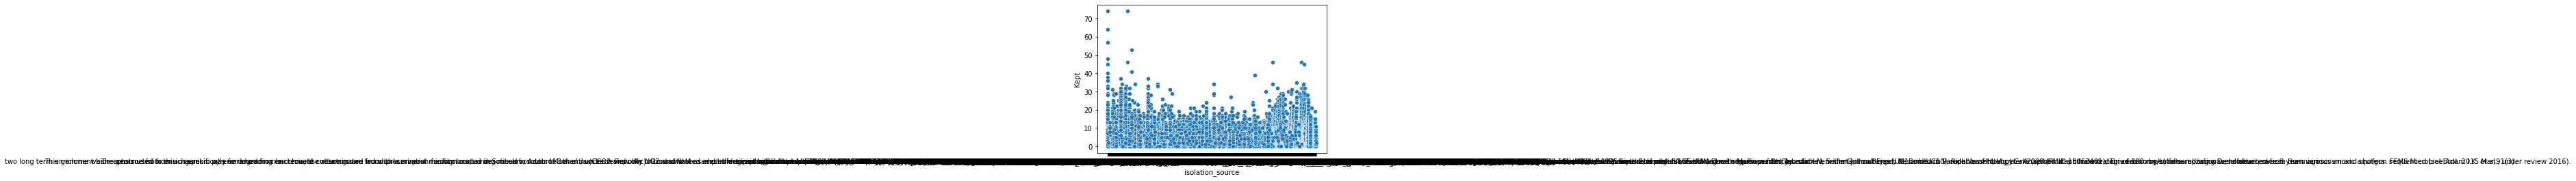

In [128]:
cdnn = phagemeta[phagemeta['isolation_source'].notnull()][['isolation_source', 'Kept']]
sns.scatterplot(x='isolation_source', y='Kept', data=cdnn)

<AxesSubplot:xlabel='collection_date', ylabel='Kept'>

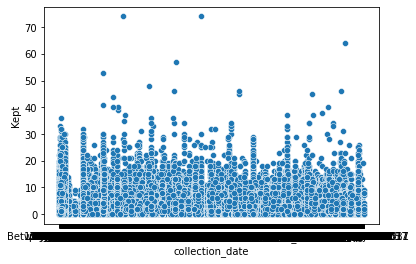

In [127]:
cdnn = phagemeta[phagemeta['collection_date'].notnull()][['collection_date', 'Kept']]
sns.scatterplot(x='collection_date', y='Kept', data=cdnn)

### Selected columns

Here we are going to choose a one or a few columns and then strip out the `NaNs` and run a linear regression using 

In [ ]:
# add the other columns. Not sure if we need this.
for c in phagemeta.iloc[:,30:].columns:
    pmenc[c] = phagemeta[c]

In [41]:
# which data frame are we going to use here.
# df = scdnonzero
df =  pmenc[pmenc['isolation_source'] > -1][['isolation_source', 'Kept']]
df

,isolation_source,Kept
1,5261,1
2,8897,6
3,6481,6
4,8897,3
5,8897,3
...,...,...
403547,1762,3
403548,2025,2
403549,1762,0
403550,1762,1


In [55]:
df.isolation_source.unique().shape

(10365,)

In [57]:
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(df.iloc[:,0:1], df.iloc[:,1:2].values.ravel())
print(rf)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=42)


In [58]:
rf.oob_score_

0.3058384816608226

In [60]:
rf.oob_decision_function_

array([[0.00000000e+00, 0.00000000e+00, 2.78551532e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.76457745e-02, 9.62093961e-02, 1.22119896e-01, ...,
        4.97938081e-04, 4.58555109e-04, 4.84161103e-04],
       [1.04176796e-01, 0.00000000e+00, 7.82601164e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.64883969e-02, 5.16391268e-02, 3.88681135e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.04956472e-02, 4.45838656e-02, 3.90779676e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.29213483e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [45]:
fi = pd.DataFrame(zip(df.iloc[:,1:].columns, rf.feature_importances_), columns=['feature', 'importance'])
fi.sort_values('importance', ascending=False).head(5)

,feature,importance
0,Kept,1.0
